In [13]:
import skimage
import scipy
import time
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from skimage import filters
from sklearn.cluster import KMeans
import cv2
from sklearn import metrics
import sys

## Load data

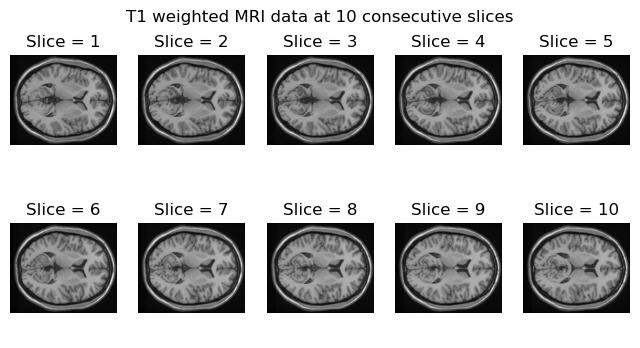

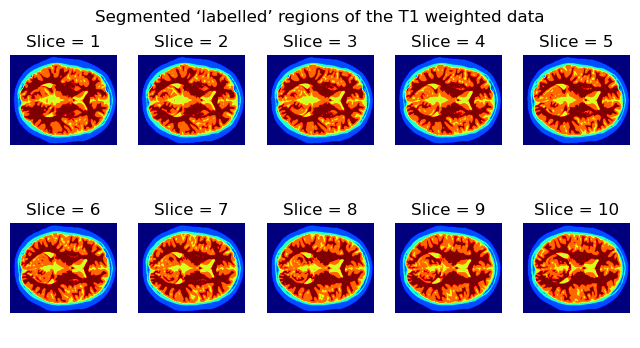

In [14]:
# Load data

data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']

# Display T1 images

fig = plt.figure(figsize=(8, 4))
plt.title("T1 weighted MRI data at 10 consecutive slices")
plt.axis('off')

for i in range(T1.shape[2]):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.title("Slice = {}".format(i+1))
    plt.imshow(T1[:,:,i], cmap = 'gray')
    
# Display labels
    
fig = plt.figure(figsize=(8, 4))
plt.title("Segmented ‘labelled’ regions of the T1 weighted data")
plt.axis('off')

for i in range(label.shape[2]):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.title("Slice = {}".format(i+1))
    plt.imshow(label[:,:,i], cmap = 'jet')

(-0.5, 433.5, 361.5, -0.5)

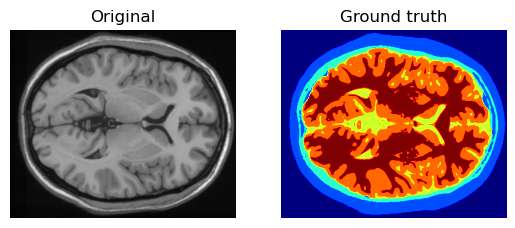

In [15]:
original_img = T1[:,:,0]
ground_truth_img = label[:,:,0]
img = original_img

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(ground_truth_img, cmap = 'jet')
ax[1].set_title('Ground truth')
ax[1].axis('off')

## Step 1 - Thresholding to binarize image

In [16]:
def otsu_thresholding(img):
    img_r = img.reshape(img.shape[0]*img.shape[1])
    thresh = filters.threshold_otsu(img)
    for i in range(img_r.shape[0]):
        if img_r[i] > thresh:
            img_r[i] = 1
        else:
            img_r[i] = 0    
    img = img_r.reshape(img.shape[0], img.shape[1])
    return img

img_thresholded = otsu_thresholding(img)

(-0.5, 433.5, 361.5, -0.5)

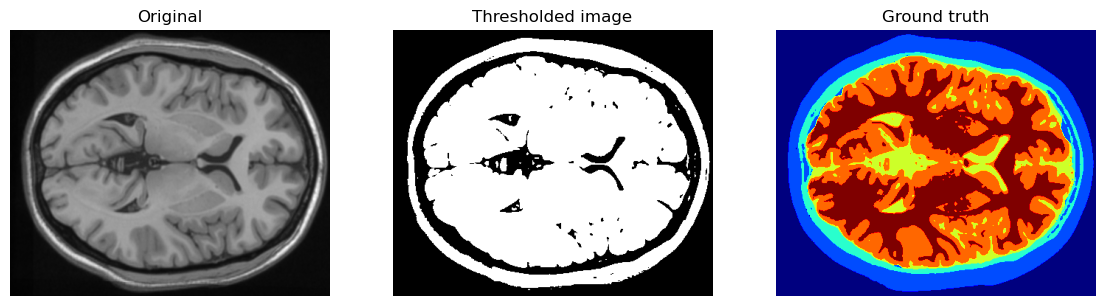

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 3.5))

ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(img_thresholded, cmap = "gray")
ax[1].set_title('Thresholded image')
ax[1].axis('off')

ax[2].imshow(ground_truth_img, cmap = 'jet')
ax[2].set_title('Ground truth')
ax[2].axis('off')

## Step 2 - Segmenting contours of skin, skull and outer CSF with Marching cubes algorithm

In [18]:
# Flips x and y coordinates of contour as numpy array
def flip_coordinates(contour):
    contour_r = contour[:, 1]
    contour_r = np.stack((contour_r, contour[:, 0]), axis = 1)
    return contour_r

# Finding most significant contours using Marching cubes algorithm
def finding_significant_contours(img, count):
    contours = skimage.measure.find_contours(img)
    # Sorting in descending order of contour length
    n = len(contours)
    for i in range(n-1):
        for j in range(0, n-i-1):
            if len(contours[j]) < len(contours[j+1]):
                contours[j], contours[j+1] = contours[j+1], contours[j]
    significant_contours = []
    for j in range(count):
        contour = flip_coordinates(contours[j])
        significant_contours.append(contour)
    return significant_contours

# Fetching skin, CSF and skull masks from contours
def fetch_masks_from_contours(img, contours):
    # Separating skin mask
    contour_skin = contours[1]
    skin_mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(skin_mask, np.int32([contour_skin]), 1)
    # Separating csf mask
    contour_csf = contours[0]
    csf_mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(csf_mask, np.int32([contour_csf]), 1)
    # Separating skull mask
    contour_skull = contours[2]
    skull_mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(skull_mask, np.int32([contour_skull]), 1)
    return skin_mask, skull_mask, csf_mask

# Segmenting Air, skin, skull and CSF from their masks
def segment_regions_from_masks(img, skin_mask, skull_mask, csf_mask):
    # Segmenting skin, air and skull
    img_segmented = skin_mask
    img_r = img_segmented.reshape(img.shape[0]*img.shape[1])
    skull_mask_r = skull_mask.reshape(img.shape[0]*img.shape[1])
    for i in range(img_r.shape[0]):
        if img_r[i] == 1:
            if skull_mask_r[i] == 0:
                img_r[i] = 1
            else:
                img_r[i] = 2
            
    img_segmented = img_r.reshape(img.shape[0], img.shape[1])
    # Segmenting CSF from skull

    img_r = img_segmented.reshape(img.shape[0]*img.shape[1])
    csf_mask_r = csf_mask.reshape(img.shape[0]*img.shape[1])

    for i in range(img_r.shape[0]):
        if img_r[i] == 2:
            if csf_mask_r[i] == 0:
                img_r[i] = 2
            else:
                img_r[i] = 3
            
    img_segmented = img_r.reshape(img.shape[0], img.shape[1])
    return img_segmented

# Fetching MRI values inside CSF mask
def fetch_csf_mri(img, csf_mask):
    img_r = img.reshape(img.shape[0]*img.shape[1])
    csf_mask_r = csf_mask.reshape(img.shape[0]*img.shape[1])
    img_csf = np.zeros(img.shape[0] * img.shape[1])
    for i in range(img_r.shape[0]):
        if csf_mask_r[i] == 1:
            img_csf[i] = img_r[i] 
            
    img_csf = img_csf.reshape(img.shape[0], img.shape[1])
    return img_csf

In [19]:
# Find contours of skin, skull and CSF
contours = finding_significant_contours(img_thresholded, 3)
# Fetch masks from the contours 
skin_mask, skull_mask, csf_mask = fetch_masks_from_contours(img_thresholded, contours)
# Segment  Air, skin, skull and CSF regions from masks
img_segmented = segment_regions_from_masks(img_thresholded, skin_mask, skull_mask, csf_mask)
# Segmenting regions within CSF - CSF, grey matter and white matter
img_csf = fetch_csf_mri(img, csf_mask)

(-0.5, 433.5, 361.5, -0.5)

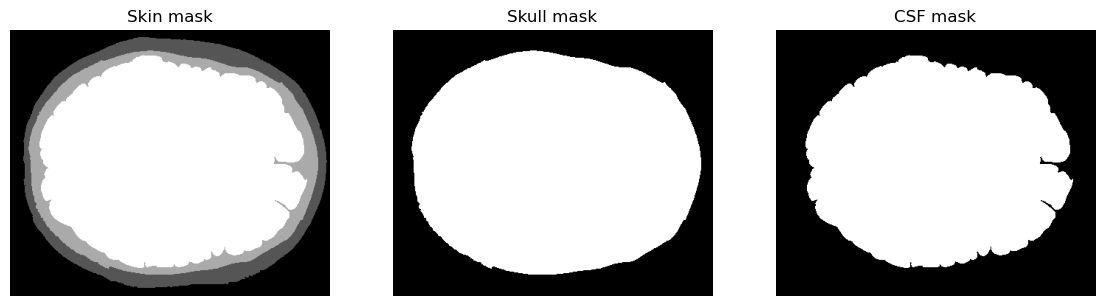

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 3.5))

ax[0].imshow(skin_mask, cmap='gray')
ax[0].set_title('Skin mask')
ax[0].axis('off')

ax[1].imshow(skull_mask, cmap='gray')
ax[1].set_title('Skull mask')
ax[1].axis('off')

ax[2].imshow(csf_mask, cmap='gray')
ax[2].set_title('CSF mask')
ax[2].axis('off')

In [21]:
np.unique(skin_mask, return_counts=True)

(array([0, 1, 2, 3], dtype=uint8), array([43714, 17757, 15526, 80111]))

(-0.5, 433.5, 361.5, -0.5)

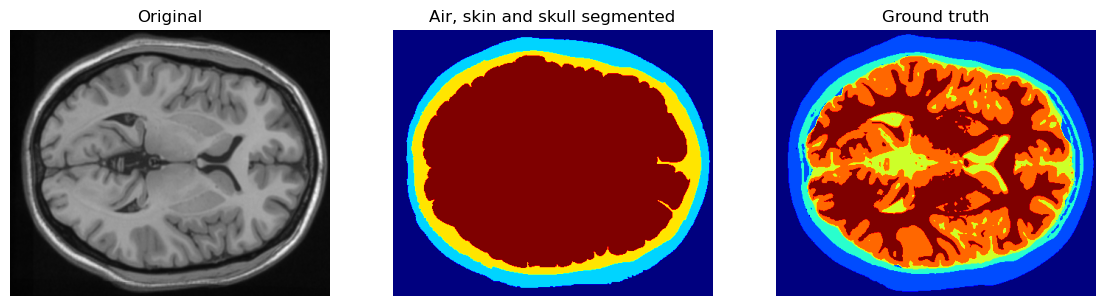

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 3.5))

ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(img_segmented, cmap = "jet")
ax[1].set_title('Air, skin and skull segmented')
ax[1].axis('off')

ax[2].imshow(ground_truth_img, cmap = 'jet')
ax[2].set_title('Ground truth')
ax[2].axis('off')

## Step 3 - Segmenting CSF, Grey Matter and white matter with Multi-Otsu thresholding

In [27]:
def segmenting_csf_with_thresholding(img_csf):
    thresholds = filters.threshold_multiotsu(img_csf, classes = 4)
    segmented_csf = np.digitize(img_csf, bins=thresholds)
    return segmented_csf 

segmented_csf = segmenting_csf_with_thresholding(img_csf)

(-0.5, 433.5, 361.5, -0.5)

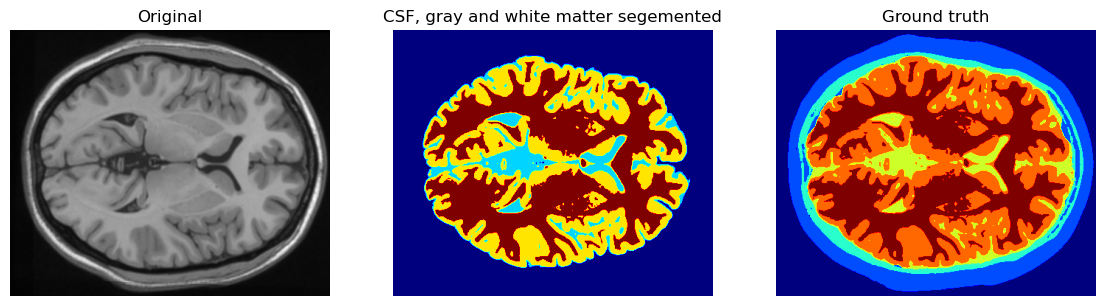

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 3.5))

ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(segmented_csf, cmap = "jet")
ax[1].set_title('CSF, gray and white matter segemented')
ax[1].axis('off')

ax[2].imshow(ground_truth_img, cmap = 'jet')
ax[2].set_title('Ground truth')
ax[2].axis('off')

## Step 4 - Combining segmentation from step 1 and 2

In [31]:
# Integrating contour segmentation with CSF segmentation
def join_segmentation(img, img_segmented, segmented_csf):
    img_r = img_segmented.reshape(img.shape[0]*img.shape[1])
    segmented_csf_r = segmented_csf.reshape(img.shape[0]*img.shape[1])
    for i in range(img_r.shape[0]):
        if img_r[i] >= 3:
            if segmented_csf_r[i] == 1:
                img_r[i] = 3
            elif segmented_csf_r[i] == 2:
                img_r[i] = 4
            elif segmented_csf_r[i] == 3:
                img_r[i] = 5
    img_segmented = img_r.reshape(img.shape[0], img.shape[1])
    return img_segmented

img_segmented_2 = join_segmentation(img, img_segmented, segmented_csf)

(-0.5, 433.5, 361.5, -0.5)

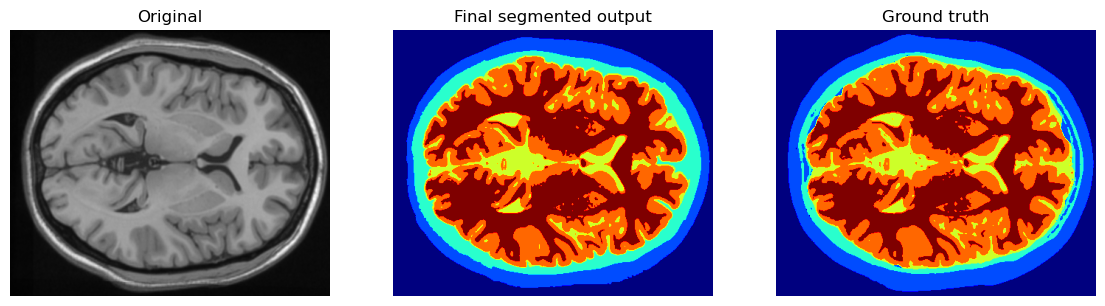

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 3.5))

ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(img_segmented_2, cmap = "jet")
ax[1].set_title('Final segmented output')
ax[1].axis('off')

ax[2].imshow(ground_truth_img, cmap = 'jet')
ax[2].set_title('Ground truth')
ax[2].axis('off')

## Overall results

In [37]:
def segment_brain_mri(img):
    # Step 1
    img_thresholded = otsu_thresholding(img)
    # Step 2
    # Find contours of skin, skull and CSF
    contours = finding_significant_contours(img_thresholded, 3)
    skin_mask, skull_mask, csf_mask = fetch_masks_from_contours(img_thresholded, contours)
    img_segmented_partial = segment_regions_from_masks(img_thresholded, skin_mask, skull_mask, csf_mask)
    img_csf = fetch_csf_mri(img, csf_mask)  
    # Step 3
    img_csf = fetch_csf_mri(img, csf_mask)
    segmented_csf = segmenting_csf_with_thresholding(img_csf)
    # Integrating first segmentation with the segmentation inside CSF
    img_segmented_output = join_segmentation(img, img_segmented_partial, segmented_csf)
    return img_segmented_output

def segment_MRIs(T1):
    T1_pred = np.zeros([T1.shape[0], T1.shape[1], T1.shape[2]])
    for i in range(T1.shape[2]):
        img = T1[:,:,i]
        T1_pred[:,:,i] = segment_brain_mri(img)
    return T1_pred

segmented_output = segment_MRIs(T1)

## Evaluation

In [40]:
def evaluation(T1_pred, labels):
    accuracy_list = []
    precision_list_macro = []
    recall_list_macro = []
    precision_list_micro = []
    recall_list_micro = []
    dice_coefficient_list = []
    for i in range(T1_pred.shape[2]):
        img_pred = T1_pred[:,:,i]
        label_img = labels[:,:,i]
        img_pred_r = img_pred.reshape(img_pred.shape[0] * img_pred.shape[1])
        label_img_r = label_img.reshape(label_img.shape[0] * label_img.shape[1])
        # Accuracy
        img_segmented_2_r = img_segmented_2.reshape(img.shape[0] * img.shape[1])
        accuracy = np.sum(img_segmented_2_r == label_img_r) / (img.shape[0] * img.shape[1])
        accuracy_list.append(accuracy)
        # Dice coefficient
        dice_coeff = metrics.f1_score(label_img_r, img_pred_r, average = 'macro')
        dice_coefficient_list.append(dice_coeff)
        # Precision and recall
        # Macro
        precision_score_macro = metrics.precision_score(label_img_r, img_segmented_2_r, average='macro')
        recall_score_macro = metrics.recall_score(label_img_r, img_segmented_2_r, average='macro')
        precision_list_macro.append(precision_score_macro)
        recall_list_macro.append(recall_score_macro)
        # Micro
        precision_score_micro = metrics.precision_score(label_img_r, img_segmented_2_r, average='micro')
        recall_score_micro = metrics.recall_score(label_img_r, img_segmented_2_r, average='micro')
        precision_list_micro.append(precision_score_micro)
        recall_list_micro.append(recall_score_micro)

    accuracy = sum(accuracy_list) / len(accuracy_list)
    print("Pixel accuracy: ", accuracy)

    precision_macro = sum(precision_list_macro) / len(precision_list_macro)
    print("Macro precision: ", precision_macro)

    recall_macro = sum(recall_list_macro) / len(recall_list_macro)
    print("Macro recall: ", recall_macro)

    precision_micro = sum(precision_list_micro) / len(precision_list_micro)
    print("Micro precision: ", precision_micro)

    recall_micro = sum(recall_list_micro) / len(recall_list_micro)
    print("Micro recall: ", recall_micro)
        
    dice_coefficient = sum(dice_coefficient_list) / len(dice_coefficient_list)
    print("Dice cofficient: ", dice_coefficient)

In [41]:
evaluation(segmented_output, label)

Pixel accuracy:  0.7843674415052067
Macro precision:  0.7412908002610687
Macro recall:  0.7590185772447171
Micro precision:  0.7843674415052067
Micro recall:  0.7843674415052067
Dice cofficient:  0.8647280222050027
